In [1]:
import numpy as onp 
import pandas as pd

import os
import json

import networkx as nx
from ns.topos.fattree import build as build_fattree

import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation, Animation

from IPython.core.display import HTML

from inference import run_simulation
from plotting import plot_egress_histogram, plot_egress_histogram_animation

In [2]:
# Generate results for all the ablation studies.
paths = []
model_names = os.listdir('../models')
for f in os.listdir('../configs'):
    
    with open(f'../configs/{f}') as fp:
        specs = json.load(fp)
    exp_name = specs['exp_name']
    model_dir = os.path.join('../models/models_may', specs["exp_name"] + "_lr_{}_steps_{}".format(specs["train_lr"],specs["n_timesteps"]))
    data_name = os.path.join(*specs['data_specs']['val_data_pth'][0].split('/')[-2:])[:-14] # Sketchy
    data_path = f'../data/{data_name}'
    if os.path.isdir(model_dir) and os.path.isfile(f'{data_path}.csv'):
        paths.append((data_path, f'../configs/{f}', os.path.join(model_dir, 'best_model.pt')))

paths

[('../data/itr5/sch_SP-tgen_Poisson-n_flows_100-n_ports_4',
  '../configs/train_no_bidir_SP_poisson_4.json',
  '../models/models_may/new_no_bidir_sch_SP-tgen_Poisson-n_flows_100-n_ports_4_lr_0.0001_steps_42/best_model.pt'),
 ('../data/itr5/sch_WFQ-tgen_Poisson-n_flows_100-n_ports_4',
  '../configs/train_no_bidir_WFQ_poisson_4.json',
  '../models/models_may/new_no_bidir_sch_WFQ-tgen_Poisson-n_flows_100-n_ports_4_lr_0.0001_steps_42/best_model.pt'),
 ('../data/itr5/sch_FIFO-tgen_Poisson-n_flows_100-n_ports_8',
  '../configs/train_no_bidir_FIFO_poisson_8.json',
  '../models/models_may/new_no_bidir_sch_FIFO-tgen_Poisson-n_flows_100-n_ports_8_lr_0.0001_steps_42/best_model.pt'),
 ('../data/itr5/sch_FIFO-tgen_Poisson-n_flows_100-n_ports_4',
  '../configs/train_no_bidir_ALL_poisson_4.json',
  '../models/models_may/new_no_bidir_sch_ALL-tgen_Poisson-n_flows_100-n_ports_4_lr_0.001_steps_42/best_model.pt'),
 ('../data/itr5/sch_FIFO-tgen_OnOff-n_flows_100-n_ports_4',
  '../configs/train_no_bidir_FIF

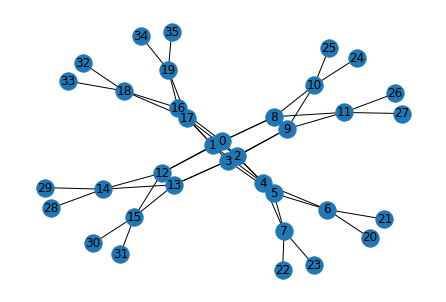

In [12]:
G = build_fattree(4)
nx.draw(G, with_labels=True)

In [4]:
# Run inference with a trained model.
for i, path in enumerate(paths):
    print(i)
    df_true, df_pred = run_simulation(G, *path)
    df_pred.to_csv(f'../inference_csvs/{path[0].split("/")[-1]}_pred.csv')
    df_true.to_csv(f'../inference_csvs/{path[0].split("/")[-1]}_true.csv')
    break

0
Simulation Setup, running IRSA
Simulation took 154.741862 seconds


In [14]:
# Here we will give an example of doing inference on a single trace.
trace_path_poisson = '../data/rsim_poisson'
trace_path_onoff = '../data/rsim_onoff'

config_path = '../configs/train_no_bidir_ALL_poisson_4.json'
model_path = '../models/models_may/new_no_bidir_sch_ALL-tgen_Poisson-n_flows_100-n_ports_4_lr_0.001_steps_42/best_model.pt'

df_true_poisson, df_pred_poisson = run_simulation(G, trace_path_poisson, config_path, model_path)
df_true_onoff, df_pred_onoff = run_simulation(G, trace_path_onoff, config_path, model_path)

Simulation Setup, running IRSA
Simulation took 269.155211 seconds
Simulation Setup, running IRSA
Simulation took 39.541862 seconds


In [21]:
# Here we will give an example of doing inference on a single trace.
trace_path_poisson = '../data/rsim_poisson'
trace_path_sp = '../data/rsim_SP'
trace_path_drr = '../data/rsim_DRR'
trace_path_wfq = '../data/rsim_WFQ'

config_path = '../configs/train_no_bidir_ALL_poisson_4.json'
model_path = '../models/models_may/new_no_bidir_sch_ALL-tgen_Poisson-n_flows_100-n_ports_4_lr_0.001_steps_42/best_model.pt'

# df_true_poisson, df_pred_poisson = run_simulation(G, trace_path_poisson, config_path, model_path)
df_true_sp, df_pred_sp = run_simulation(G, trace_path_sp, config_path, model_path)
df_true_drr, df_pred_drr = run_simulation(G, trace_path_drr, config_path, model_path)
df_true_wfq, df_pred_wfq = run_simulation(G, trace_path_wfq, config_path, model_path)

Simulation Setup, running IRSA
Simulation took 272.804896 seconds


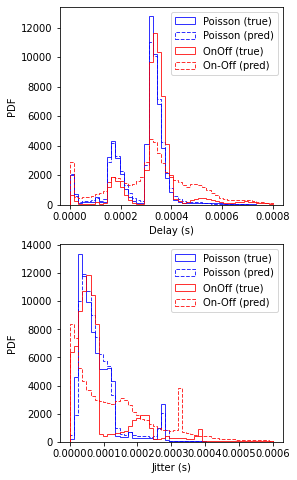

In [19]:
def plot_egress_histogram(dfs, labels, colors, styles):
    # Here we plot the animation of the egress histogram.
    fig, axes = plt.subplots(2)
    fig.set_size_inches(4, 12)
    axes[0].set_xlabel('Delay (s)')
    axes[1].set_xlabel('Jitter (s)')
    axes[0].set_ylabel('PDF')
    axes[1].set_ylabel('PDF')

    # Manual binning
    delay_bins = onp.linspace(0.0, 0.0008, 50)
    jitter_bins = onp.linspace(0.0, 0.0006, 50)

    for df, label, color, style in zip(dfs, labels, colors, styles):
        df_ = df.dropna()
        delays = (df_['etime'] - df_['timestamp']).values
        jitter = onp.abs(delays - delays.mean())
        axes[0].hist(delays, bins=delay_bins, label=label, color=color, alpha=0.8, histtype=u'step', density=True, linewidth=1, linestyle=style)
        axes[1].hist(jitter, bins=jitter_bins, label=label, color=color, alpha=0.8, histtype=u'step', density=True, linewidth=1, linestyle=style)
    axes[0].legend()
    axes[1].legend()
    plt.savefig('dqn_figure.pdf')


In [ ]:
dfs = [df_true_poisson, df_pred_poisson, df_true_onoff, df_pred_onoff]
labels = ['Poisson (true)', 'Poisson (pred)', 'OnOff (true)', 'On-Off (pred)']
colors = ['blue', 'blue', 'red', 'red']
styles = ['solid', 'dashed', 'solid', 'dashed']
plot_egress_histogram(dfs, labels, colors, styles)

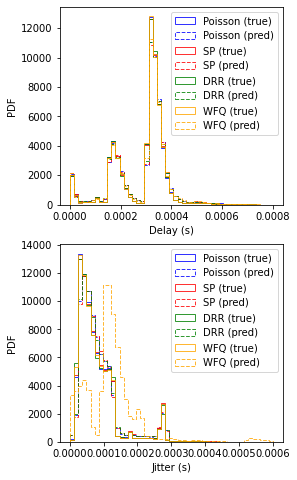

In [22]:
dfs = [df_true_poisson, df_pred_poisson, df_true_sp, df_pred_sp, df_true_drr, df_pred_drr, df_true_wfq, df_pred_wfq]
labels = ['Poisson (true)', 'Poisson (pred)', 'SP (true)', 'SP (pred)', 'DRR (true)', 'DRR (pred)', 'WFQ (true)', 'WFQ (pred)']
colors = ['blue', 'blue', 'red', 'red', 'green', 'green', 'orange', 'orange']
styles = ['solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed', 'solid', 'dashed']
plot_egress_histogram(dfs, labels, colors, styles)

-0.0003014050901448684 0.0007602456025779247
-0.0006425497413147241 0.0007236441306304187
-0.0002635326535127547 0.0009208317496813834


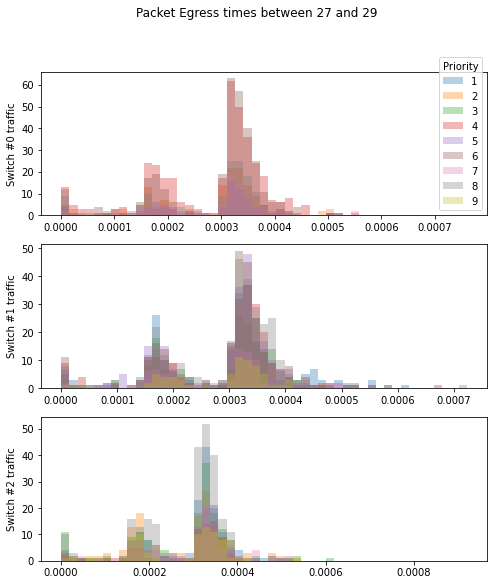

In [9]:
# Given a dataframe, we can plot the egress histograms as follows.
devices = [0, 1, 2]
df_ = df_pred.dropna(axis=0)
anim = plot_egress_histogram_animation(df_, devices)
HTML(Animation.to_jshtml(anim, fps=4))
anim.save('example_trace_pred.gif')

1.525878889907517e-07 0.0011080066297957103
0.0 0.0010711415418249715
7.629394530583866e-07 0.0009078246002509616


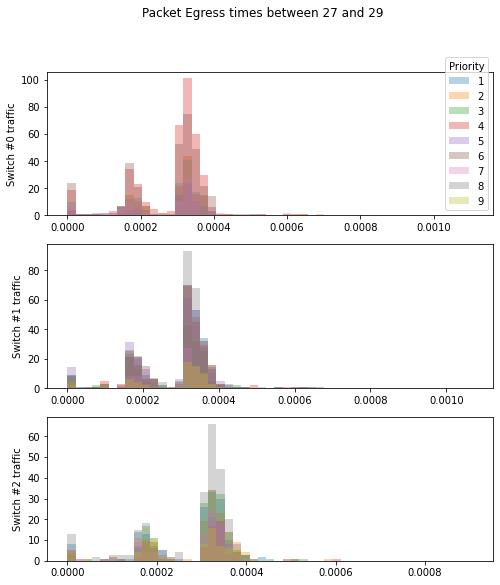

In [10]:
df_true = pd.read_csv(f'{trace_path}.csv')
anim = plot_egress_histogram(df_true, devices)
HTML(Animation.to_jshtml(anim, fps=4))
anim.save('example_trace_true.gif')

In [7]:
df_true

,timestamp,pkt_len,cur_hub,cur_port,path,priority,flow_id,scheduler,etime
0,0.000294,2262,33,0,33_0,1,3,SP,0.000639
1,0.000398,2173,27,0,27_0,1,93,SP,0.000729
2,0.000635,1143,35,0,35_0,2,56,SP,0.000810
3,0.000639,2262,18,0,33_0-18_0,1,3,SP,0.000985
4,0.000729,2173,11,0,27_0-11_0,1,93,SP,0.001061
...,...,...,...,...,...,...,...,...,...
625397,29.999629,66,6,0,20_0-6_0,2,0,SP,29.999639
625398,29.999639,66,4,3,20_0-6_0-4_3,2,0,SP,29.999649
625399,29.999649,66,1,3,20_0-6_0-4_3-1_3,2,0,SP,29.999659
625400,29.999659,66,16,1,20_0-6_0-4_3-1_3-16_1,2,0,SP,29.999669


198.2706132554101